In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pywt
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
accuracies, specificities, sensitivities = list(), list(), list()


def read_eeg_data(filename):
    """Reads EEG data from a text file.

    Args:
        filename: The path to the text file containing the EEG data.

    Returns:
        A NumPy array containing the EEG data.
    """

    with open(filename, 'r') as f:
        data = f.readlines()

    data = [float(line.strip()) for line in data]
    data = np.array(data)

    return data


# Calculate the four statistical features
def calculate_features(coeffs):
    # (1) Mean of the absolute values of the coefficients in each subband
    mean_absolute = [np.mean(np.abs(subband)) for subband in coeffs]

    # (2) Average power of the wavelet coefficients in each sub-band
    power = [np.mean(np.square(subband)) for subband in coeffs]

    # (3) Standard deviation of the coefficients in each sub-band
    std_dev = [np.std(subband) for subband in coeffs]

    # (4) Ratio of the absolute mean values of adjacent sub-bands
    adjacent_ratio = [np.abs(mean_absolute[i] / mean_absolute[i + 1]) for i in range(len(mean_absolute) - 1)]
    adjacent_ratio.append(np.abs(mean_absolute[-1] / mean_absolute[0]))

    return mean_absolute, power, std_dev, adjacent_ratio

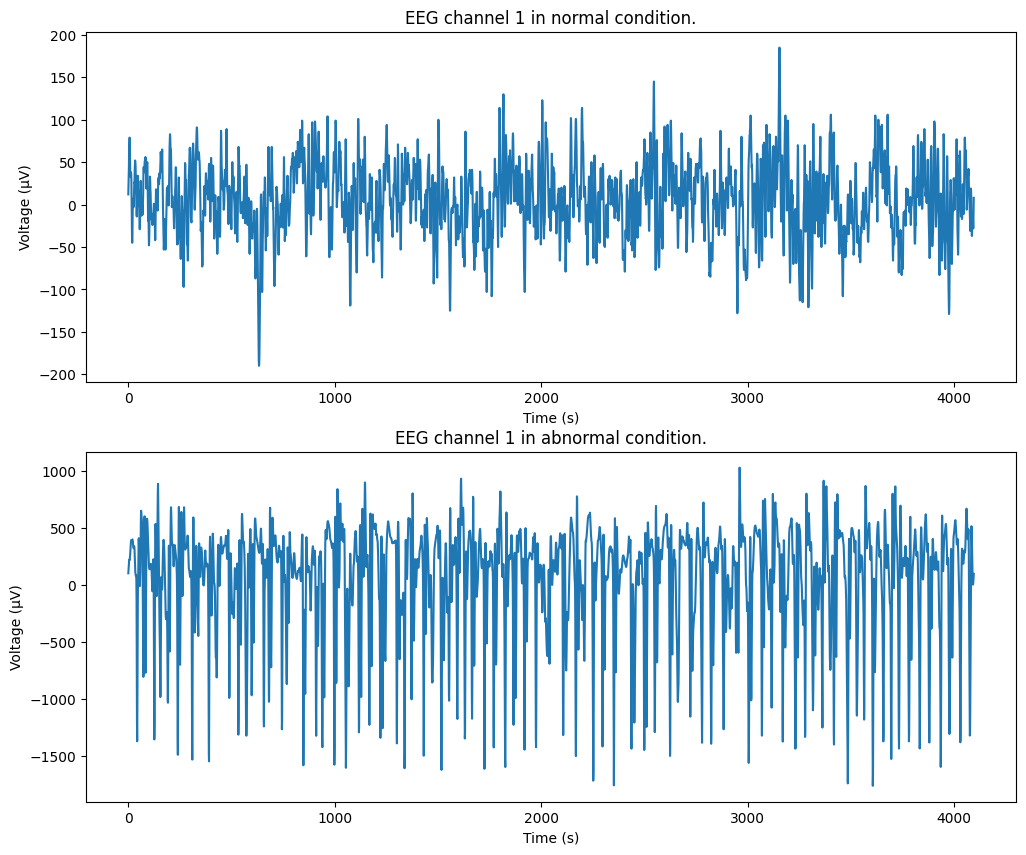

In [3]:
eeg_data_normal = []
eeg_data_abnormal = []


for i in range(1, 101):
    filename = 'Z/Z' + '0' * (3 - len(str(i))) + str(i) + '.txt'
    eeg_data_normal.append(read_eeg_data(filename)[:-1])
    
    
for i in range(1, 101):
    filename = 'S/S' + '0' * (3 - len(str(i))) + str(i) + '.txt'
    eeg_data_abnormal.append(read_eeg_data(filename)[:-1])
    
# plt.figure(figsize=(15, 15))
# fig, axs = plt.subplots(5, 5)

# for i in range(25):
#     ax = axs[i // 5, i % 5]
#     ax.plot(eeg_data[i])
#     ax.set_xlabel('Time (ms)')
#     ax.set_ylabel('Voltage (μV)')

# plt.tight_layout()
# plt.plot()

# normal = pd.DataFrame(eeg_data_normal)
# abnormal = pd.DataFrame(eeg_data_abnormal)

# normal.to_csv("normal.csv")
# abnormal.to_csv("abnormal.csv")

eeg_data_normal = np.array(eeg_data_normal)
eeg_data_abnormal = np.array(eeg_data_abnormal)

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(eeg_data_normal[0])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (μV)')
plt.title("EEG channel 1 in normal condition.")

plt.subplot(2, 1, 2)
plt.plot(eeg_data_abnormal[0])
plt.xlabel('Time (s)')
plt.ylabel('Voltage (μV)')
plt.title("EEG channel 1 in abnormal condition.")
plt.show()

## Feature Extraction
(1) Mean of the absolute values of the coefficients in each sub- band. <br>
(2) Average power of the wavelet coefficients in each sub-band. <br>
(3) Standard deviation of the coefficients in each sub-band. <br>
(4) Ratio of the absolute mean values of adjacent sub-bands.

In [4]:
mean_normal, avg_power_normal, std_normal, ratio_normal = list(), list(), list(), list()
mean_abnormal, avg_power_abnormal, std_abnormal, ratio_abnormal = list(), list(), list(), list()


for i in range(100):
    # Define a sample EEG signal (replace with your actual signal data)
    eeg_signal_normal = eeg_data_normal[i]  # Replace with your EEG data
    eeg_signal_abnormal = eeg_data_abnormal[i]

    # Define the wavelet parameters (you can choose a different wavelet and level)
    wavelet = 'db4'
    level = 5

    # Apply wavelet transform
    coeffs_normal = pywt.wavedec(eeg_signal_normal, wavelet, level=level)
    coeffs_abnormal = pywt.wavedec(eeg_signal_abnormal, wavelet, level=level)

    # Calculate the four statistical features
    
    mean_absolute, power, std_dev, adjacent_ratio = calculate_features(coeffs_normal)
    mean_normal.append(mean_absolute[:-2])
    avg_power_normal.append(power[:-2])
    std_normal.append(std_dev[:-2])
    ratio_normal.append(adjacent_ratio[:-2])
    
    mean_absolute2, power2, std_dev2, adjacent_ratio2 = calculate_features(coeffs_abnormal)
    mean_abnormal.append(mean_absolute2[:-2])
    avg_power_abnormal.append(power2[:-2])
    std_abnormal.append(std_dev2[:-2])
    ratio_abnormal.append(adjacent_ratio2[:-2])



# Print or use the calculated features
# print("Mean Absolute Values in Subbands:", mean_normal)
# print("Average Power in Subbands:", avg_power_normal)
# print("Standard Deviation in Subbands:", std_normal)
# print("Ratio of Absolute Mean Values of Adjacent Sub-bands:", ratio_normal)

mean_normal = np.array(mean_normal)
avg_power_normal = np.array(avg_power_normal)
std_normal = np.array(std_normal)
ratio_normal = np.array(ratio_normal)
    
mean_abnormal = np.array(mean_abnormal)
avg_power_abnormal = np.array(avg_power_abnormal)
std_abnormal = np.array(std_abnormal)
ratio_abnormal = np.array(ratio_abnormal)

X_normal = np.concatenate((mean_normal, avg_power_normal, std_normal, ratio_normal), axis=1)
Y_normal = np.zeros(len(X_normal))
X_abnormal = np.concatenate((mean_abnormal, avg_power_abnormal, std_abnormal, ratio_abnormal), axis=1)
Y_abnormal = np.ones(len(X_abnormal))

X = np.concatenate((X_normal, X_abnormal), axis=0)
y = np.concatenate((Y_normal, Y_abnormal), axis=0)

In [5]:
# Train test splitting.

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
sss.get_n_splits(X, y)

for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    train_indices = train_index
    test_indices = test_index
    
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

In [6]:
print(f"Training set size: {X_train.shape}")
print(f"Epileptic cases in training set: {np.sum(y_train)}")
print(f"Normal cases in training set: {len(y_train) - np.sum(y_train)}\n")

print(f"Test set size: {X_test.shape}")
print(f"Epileptic cases in test set: {np.sum(y_test)}")
print(f"Normal cases in test set: {len(y_test) - np.sum(y_test)}")

Training set size: (100, 16)
Epileptic cases in training set: 50.0
Normal cases in training set: 50.0

Test set size: (100, 16)
Epileptic cases in test set: 50.0
Normal cases in test set: 50.0


### Linear Descriminant Analysis

In [7]:
# Preprocess and rescale data.

Scaler = StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

# Apply LDA to reduce dimensions.

lda = LinearDiscriminantAnalysis()
X_train_reduced = lda.fit_transform(X_train_scaled, y_train)
X_test_reduced = lda.transform(X_test_scaled)

In [8]:
# Train SVC and evaluate.

clf = SVC()
clf.fit(X_train_reduced, y_train)

print(f"Accuracy score for train set: {clf.score(X_train_reduced, y_train)}")
print(f"Accuracy score for test set: {clf.score(X_test_reduced, y_test)}")

Accuracy score for train set: 1.0
Accuracy score for test set: 1.0


In [9]:
# Confusion Matrix Stats

y_train_pred = clf.predict(X_train_reduced)
y_test_pred = clf.predict(X_test_reduced)

CM_train = confusion_matrix(y_train, y_train_pred)
CM_test = confusion_matrix(y_test, y_test_pred)

print("Train set")
print(f"Sensitivity: {CM_train[1][1] / (CM_train[1][1] + CM_train[1][0])}")
print(f"Specificity: {CM_train[0][0] / (CM_train[0][1] + CM_train[0][0])}")

print("\nTest set")
print(f"Sensitivity: {CM_test[1][1] / (CM_test[1][1] + CM_test[1][0])}")
print(f"Specificity: {CM_test[0][0] / (CM_test[0][1] + CM_test[0][0])}\n")

accuracies.append(np.round(clf.score(X_test_reduced, y_test) * 100, 2))
sensitivities.append(np.round(CM_test[1][1] / (CM_test[1][1] + CM_test[1][0]) * 100, 2))
specificities.append(np.round(CM_test[0][0] / (CM_test[0][1] + CM_test[0][0]) * 100, 2))

Train set
Sensitivity: 1.0
Specificity: 1.0

Test set
Sensitivity: 1.0
Specificity: 1.0



### Principal Component Analysis

In [10]:
# Scale data before applying PCA.

Scaler = StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

In [11]:
# Apply PCA to identify important components
# Choose minimum number of components such that the minimum 95% variance is retained.
pca = PCA(0.95)
pca.fit(X_train_scaled)
# pca.n_components_ = 70
print(f"Num of components: {pca.n_components_}")

X_train_reduced = pca.transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

Num of components: 5


In [12]:
# Train SVC using reduced data.

clf = SVC()
clf.fit(X_train_reduced, y_train)

print(f"Accuracy score for train set: {clf.score(X_train_reduced, y_train)}")
print(f"Accuracy score for test set: {clf.score(X_test_reduced, y_test)}")

Accuracy score for train set: 0.99
Accuracy score for test set: 0.99


In [13]:
# Confusion Matrix Stats

y_train_pred = clf.predict(X_train_reduced)
y_test_pred = clf.predict(X_test_reduced)

CM_train = confusion_matrix(y_train, y_train_pred)
CM_test = confusion_matrix(y_test, y_test_pred)

print("Train set")
print(f"Sensitivity: {CM_train[1][1] / (CM_train[1][1] + CM_train[1][0])}")
print(f"Specificity: {CM_train[0][0] / (CM_train[0][1] + CM_train[0][0])}")

print("\nTest set")
print(f"Sensitivity: {CM_test[1][1] / (CM_test[1][1] + CM_test[1][0])}")
print(f"Specificity: {CM_test[0][0] / (CM_test[0][1] + CM_test[0][0])}\n")

accuracies.append(np.round(clf.score(X_test_reduced, y_test) * 100, 2))
sensitivities.append(np.round(CM_test[1][1] / (CM_test[1][1] + CM_test[1][0]) * 100, 2))
specificities.append(np.round(CM_test[0][0] / (CM_test[0][1] + CM_test[0][0]) * 100, 2))

Train set
Sensitivity: 0.98
Specificity: 1.0

Test set
Sensitivity: 0.98
Specificity: 1.0



### Independent Component Analysis

In [14]:
# Apply ICA to extract independant components from the 16 features.

ica = FastICA(n_components=14, algorithm='deflation', whiten='unit-variance')
X_train_components = ica.fit_transform(X_train)
X_test_components = ica.transform(X_test)

In [15]:
# Train SVC using reduced data.

clf = SVC()
clf.fit(X_train_components, y_train)

print(f"Accuracy score for train set: {clf.score(X_train_components, y_train)}")
print(f"Accuracy score for test set: {clf.score(X_test_components, y_test)}")

Accuracy score for train set: 1.0
Accuracy score for test set: 0.99


In [16]:
# Confusion Matrix Stats

y_train_pred = clf.predict(X_train_components)
y_test_pred = clf.predict(X_test_components)

CM_train = confusion_matrix(y_train, y_train_pred)
CM_test = confusion_matrix(y_test, y_test_pred)

print("Train set")
print(f"Sensitivity: {CM_train[1][1] / (CM_train[1][1] + CM_train[1][0])}")
print(f"Specificity: {CM_train[0][0] / (CM_train[0][1] + CM_train[0][0])}")

print("\nTest set")
print(f"Sensitivity: {CM_test[1][1] / (CM_test[1][1] + CM_test[1][0])}")
print(f"Specificity: {CM_test[0][0] / (CM_test[0][1] + CM_test[0][0])}\n")

accuracies.append(np.round(clf.score(X_test_components, y_test) * 100, 2))
sensitivities.append(np.round(CM_test[1][1] / (CM_test[1][1] + CM_test[1][0]) * 100, 2))
specificities.append(np.round(CM_test[0][0] / (CM_test[0][1] + CM_test[0][0]) * 100, 2))

Train set
Sensitivity: 1.0
Specificity: 1.0

Test set
Sensitivity: 1.0
Specificity: 0.98



### Summary of results.

In [17]:
index = ["LDA(%)", "PCA(%)", "ICA(%)"]
results = np.array([index, accuracies, specificities, sensitivities]).T

result_df = pd.DataFrame(results, columns=["Feature Extraction Method", "Accuracy", "Specificity", "Sensitivity"])
result_df.set_index("Feature Extraction Method", inplace=True)
print(result_df)

                          Accuracy Specificity Sensitivity
Feature Extraction Method                                 
LDA(%)                       100.0       100.0       100.0
PCA(%)                        99.0       100.0        98.0
ICA(%)                        99.0        98.0       100.0
